## Install OpenAI, LangGraph and LangChain dependencies

In [ ]:
!pip install langchain==0.3.27 langchain-community==0.3.27 langchain-openai==0.3.30 langgraph==0.6.5 --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.4/74.4 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.2/153.2 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 450.8/450.8 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.6/948.6 kB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 1.9 MB/s eta 0:00:00


## Configure API Keys & Environment

Set your OpenAI API key for `ChatOpenAI` and set it in the environment

In [ ]:
import os
import getpass

# OpenAI API Key (for chat & embeddings)
if not os.environ.get("OPENAI_API_KEY"):
    os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API key (https://platform.openai.com/account/api-keys):\n")


Enter your OpenAI API key (https://platform.openai.com/account/api-keys):
··········


## Imports

In [ ]:
from typing import Annotated, Literal
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from langgraph.prebuilt import create_react_agent
from IPython.display import display, Markdown

## Sample Data (Guidelines, Care Plans, Patient Records)

This notebook uses **in-memory** Python lists to keep the demo self-contained.  
You can later swap these out for a database or API without changing the agent’s logic.

### What’s included
- **`medical_guidelines`** — evidence-style rules the agent can match against.
  - Fields: `procedure`, `diagnosis`, `required_symptoms` (list), `notes` (free text).
  - Example:
    ```python
    {
      "procedure": "CT Abdomen",
      "diagnosis": "Suspected Appendicitis",
      "required_symptoms": ["abdominal pain", "nausea", "RLQ tenderness"],
      "notes": "CT imaging justified if appendicitis is unclear."
    }
    ```
- **`care_recommendations`** — next-step suggestions keyed by diagnosis.
  - Fields: `diagnosis`, `next_step`.
  - Example:
    ```python
    {
      "diagnosis": "Community-Acquired Pneumonia",
      "next_step": "Start empirical antibiotics; reserve CT for poor responders."
    }
    ```
- **`patient_records`** — patient data including what **procedure** has been recommended to them based on their **diagnosis**.
  - Fields: `patient_id`, `age`, `sex`, `symptoms` (list), `diagnosis`, `procedure`, `notes`.
  - Example:
    ```python
    {
      "patient_id": "P101",
      "age": 38,
      "sex": "Male",
      "symptoms": ["abdominal pain", "nausea"],
      "diagnosis": "Possible early appendicitis",
      "procedure": "CT Abdomen",
      "notes": "Mild abdominal pain and nausea but no localized tenderness or rebound noted."
    }
    ```

### How the agent uses these
- **Guideline matching**: `procedure` + `diagnosis` → pick the closest entry in `medical_guidelines`.
- **Validity check**: compare `patient_records[*].symptoms` vs. `required_symptoms` and read `notes`.
- **Care plan**: map `diagnosis` → `care_recommendations[*].next_step`.

In [ ]:
medical_guidelines = [
    {"procedure": "MRI Brain", "diagnosis": "Migraine", "required_symptoms": ["headache", "nausea"],
     "notes": "MRI not recommended unless neurological deficits or red flags present."},
    {"procedure": "CT Chest", "diagnosis": "Suspected Pulmonary Embolism", "required_symptoms": ["chest pain", "shortness of breath", "tachycardia"],
     "notes": "CTPA appropriate for high probability PE cases with positive D-dimer."},
    {"procedure": "MRI Lumbar Spine", "diagnosis": "Chronic Low Back Pain", "required_symptoms": ["back pain > 6 weeks", "neurological deficit"],
     "notes": "MRI only if pain persists despite conservative therapy and neuro signs are present."},
    {"procedure": "CT Chest", "diagnosis": "Community-Acquired Pneumonia", "required_symptoms": ["fever", "cough"],
     "notes": "CT Chest reserved for inconclusive X-rays or immunocompromised patients."},
    {"procedure": "CT Abdomen", "diagnosis": "Suspected Appendicitis", "required_symptoms": ["abdominal pain", "nausea", "RLQ tenderness"],
     "notes": "CT imaging justified if appendicitis is unclear."}
]

care_recommendations = [
    {"diagnosis": "Migraine", "next_step": "Start migraine treatment; imaging not necessary unless red flags appear."},
    {"diagnosis": "Suspected Pulmonary Embolism", "next_step": "Begin anticoagulation and confirm with CTPA."},
    {"diagnosis": "Chronic Low Back Pain", "next_step": "Refer to physiotherapy; MRI only if neuro symptoms persist."},
    {"diagnosis": "Community-Acquired Pneumonia", "next_step": "Start empirical antibiotics; reserve CT for poor responders."},
    {"diagnosis": "Suspected Appendicitis", "next_step": "Do CT to confirm and refer for surgery if positive."}
]

patient_records = [
    {"patient_id": "P101", "age": 38, "sex": "Male", "symptoms": ["abdominal pain", "nausea"],
     "diagnosis": "Possible early appendicitis", "procedure": "CT Abdomen",
     "notes": "Mild abdominal pain and nausea but no localized tenderness or rebound noted."},
    {"patient_id": "P102", "age": 65, "sex": "Female", "symptoms": ["chest pain", "shortness of breath", "tachycardia"],
     "diagnosis": "Clinical suspicion of PE", "procedure": "CT Chest",
     "notes": "Wells score high probability; D-dimer positive."},
    {"patient_id": "P103", "age": 30, "sex": "Female", "symptoms": ["recurrent headache"],
     "diagnosis": "Classic migraine presentation", "procedure": "MRI Brain",
     "notes": "No neuro signs or red flags. Typical migraine pattern."}
]

### Tools for the Utilization Review Agent

These are **tools** (decorated with `@tool`) that the agent can call during a review.  
They encapsulate domain logic and return **small, structured dicts** the agent can reason over.

#### Summary of tools

| Tool | Purpose | Inputs | Output keys |
|---|---|---|---|
| `fetch_patient_record` | Retrieve and summarize a patient chart from in-memory data | `patient_id: str` | `patient_summary` _(str)_, or `error` |
| `match_guideline` | Pick the closest clinical guideline for a (procedure, diagnosis) pair using the LLM | `procedure: str`, `diagnosis: str` | `matched_guideline` _(str)_ |
| `check_guideline_validity` | Validate whether patient symptoms/notes meet the guideline’s criteria | `symptoms: list[str]`, `required_symptoms: list[str]`, `notes: str` | `validity_result` _(str)_ |
| `recommend_care_plan` | Suggest next steps for the given diagnosis | `diagnosis: str` | `recommendation` _(str)_ |

> All LLM-backed tools use `ChatOpenAI` (temperature = 0, streaming enabled in code) and return **concise textual justifications** under a single key.

#### Typical call order used by the agent
1. `fetch_patient_record(patient_id)` → summarize context  
2. `match_guideline(procedure, diagnosis)` → find best-fit rule  
3. `check_guideline_validity(symptoms, required_symptoms, notes)` → approve vs. needs review  
4. `recommend_care_plan(diagnosis)` → action steps / alternatives

#### Example outputs (shape)
```json
// fetch_patient_record
{ "patient_summary": "Patient ID: P102\nAge: 65, Sex: Female\nReported Symptoms: chest pain, shortness of breath, tachycardia\nPreliminary Diagnosis: Clinical suspicion of PE\nRequested Procedure: CT Chest\nClinical Notes: Wells score high probability; D-dimer positive." }

// match_guideline
{ "matched_guideline": "CTPA is appropriate for high-probability PE with positive D-dimer. Required symptoms: chest pain, shortness of breath, tachycardia. Caveats: ensure renal function adequate for contrast." }

// check_guideline_validity
{ "validity_result": "Criteria met: symptoms align and notes indicate high probability (Wells) with positive D-dimer. Imaging is medically necessary." }

// recommend_care_plan
{ "recommendation": "Begin anticoagulation and confirm with CTPA; monitor hemodynamics; consider risk stratification." }


In [ ]:
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

@tool
def fetch_patient_record(patient_id: str) -> dict:
    """
    Fetches and summarizes a patient record based on the given patient ID.

    Returns a human-readable summary including age, sex, symptoms, diagnosis, procedure, and clinical notes.
    Also includes the raw patient record in case other tools or agents need structured access.

    Args:
        patient_id (str): The unique identifier for the patient.

    Returns:
        dict: {
            "summary": str,  # Natural language summary of the patient record
        }
    """
    for record in patient_records:
        if record["patient_id"] == patient_id:
            summary = (
                f"Patient ID: {record['patient_id']}\n"
                f"Age: {record['age']}, Sex: {record['sex']}\n"
                f"Reported Symptoms: {', '.join(record['symptoms'])}\n"
                f"Preliminary Diagnosis: {record['diagnosis']}\n"
                f"Requested Procedure: {record['procedure']}\n"
                f"Clinical Notes: {record['notes']}"
            )
            return {
                "patient_summary": summary
            }
    return {"error": "Patient record not found."}


@tool
def match_guideline(procedure: str, diagnosis: str) -> dict:
    """
    Match a given procedure and diagnosis to the most relevant clinical guideline.

    Args:
        procedure (str): The medical procedure being requested.
        diagnosis (str): The diagnosis related to the procedure.

    Returns:
        dict: A summary of the best matching guideline if found, or a message indicating no match.
    """
    context = "\n".join([
        f"{i+1}. Procedure: {g['procedure']}, Diagnosis: {g['diagnosis']}, Required Symptoms: {g['required_symptoms']}, Notes: {g['notes']}"
        for i, g in enumerate(medical_guidelines)])

    prompt = f"""You are a clinical reviewer assessing whether a requested medical procedure aligns with existing evidence-based guidelines.

Instructions:
- Analyze the patient's procedure and diagnosis.
- Compare against the list of provided clinical guidelines.
- Select the guideline that best fits the case by reasoning on the common matches considering procedure and diagnosis.
- If none match, respond: "No appropriate guideline found for this case."
- If a match is found, summarize the matching guideline clearly including any required symptoms or caveats.

Patient Case:
- Procedure: {procedure}
- Diagnosis: {diagnosis}

Available Guidelines:
{context}
"""
    result = llm.invoke(prompt).content
    return {"matched_guideline": result}


@tool
def check_guideline_validity(symptoms: list, required_symptoms: list, notes: str) -> dict:
    """
    Determine whether the patient's symptoms and notes satisfy the guideline criteria for medical necessity.

    Args:
        symptoms (list): List of symptoms recorded in the patient’s record.
        required_symptoms (list): List of symptoms required by the matched guideline.
        notes (str): Free-text clinical notes associated with the patient case.

    Returns:
        dict: A string with justification explaining whether the procedure is valid or not.
    """
    prompt = f"""You are validating a medical procedure request based on documented symptoms and clinical context.

Instructions:
- Assess whether the patient's symptoms and notes fulfill the required guideline criteria.
- Consider nuances or indirect references (e.g. "long flight" implies immobility).
- Provide a reasoned judgment if the procedure is medically necessary.
- If it does not qualify, explain exactly which criteria are unmet.

Input:
- Patient Symptoms: {symptoms}
- Required Symptoms from Guideline: {required_symptoms}
- Clinical Notes: {notes}
"""
    result = llm.invoke(prompt).content
    return {"validity_result": result}


@tool
def recommend_care_plan(diagnosis: str) -> dict:
    """
    Recommend a follow-up care plan based on a given diagnosis.

    Args:
        diagnosis (str): The diagnosis to evaluate for next steps.

    Returns:
        dict: A recommendation string describing the suggested care plan or a fallback message if no match is found.
    """
    options = "\n".join([
        f"{i+1}. Diagnosis: {c['diagnosis']}, Recommendation: {c['next_step']}"
        for i, c in enumerate(care_recommendations)])

    prompt = f"""You are a clinical support assistant suggesting appropriate next steps for a given medical diagnosis.

Instructions:
- Analyze the given diagnosis.
- Choose the closest match from the list of known recommendations.
- Explain why the match is appropriate.
- If no suitable recommendation is found, return: "No care recommendation found for this diagnosis."

Diagnosis Provided:
{diagnosis}

Available Recommendations:
{options}
"""
    result = llm.invoke(prompt).content
    return {"recommendation": result}

## Single-Agent System

The diagram illustrates a **single-agent architecture** for healthcare decision support.  
Unlike the multi-agent setup, all responsibilities are managed by one agent that coordinates tool usage directly.

![](https://i.imgur.com/s9hSJ6l.png)

#### 1. Central Agent
- Operates with a **System Prompt** and an **LLM**.  
- Handles **intake, guideline validation, and care recommendations** in one unified flow.  
- Decides when and how to call tools to process patient data and reach decisions.

#### 2. Tools Layer
- The agent directly invokes tools for each task:  
  -  **Fetch Patient Record** – retrieves patient history from the dataset  
  -  **Match Guideline** – finds relevant medical guideline for diagnosis  
  -  **Check Guideline Validity** – verifies if symptoms meet required criteria  
  -  **Fetch Recommendation** – suggests treatments or interventions  

#### 3. Datasets Layer
- **Patient Records** – stores structured patient data  
- **Medical Guidelines** – reference standards for diagnosis and procedures  
- **Care Recommendations** – library of treatment or care pathways  

#### 4. Final Output
- The single agent consolidates results from all tools.  
- Produces a **Final Decision Output** including:  
  - Decision status  
  - Reasoning  
  - Recommended next steps  

In [ ]:
single_agent_prompt = """
You are a senior medical review assistant responsible for evaluating healthcare procedure requests.

You must call relevant tools to do the following:
1. Retrieve the full patient record using the patient ID.
2. Match the requested procedure and diagnosis to clinical guidelines.
3. Validate the match by comparing the patient's symptoms and notes to the guideline's requirements.
4. Recommend the appropriate next steps based on the diagnosis.
5. Output a final summary based on the guidelines given below.

Analyze all the results from the tool calls before making the final decision

Your final response should ONLY include the following bullets in the exact format specified:

- Final Decision: [APPROVED/NEEDS REVIEW]
- Decision Reasoning: [What criteria matched or did not match]
- Care recommendation or alternative steps: [care plan steps to take or alternative steps if it needs review]

Do NOT add any other extra content in the final response
"""
AGENT_SYS_PROMPT = SystemMessage(content=single_agent_prompt)

single_agent = create_react_agent(
    model=llm,
    tools=[fetch_patient_record, match_guideline, check_guideline_validity, recommend_care_plan],
    prompt=AGENT_SYS_PROMPT
)

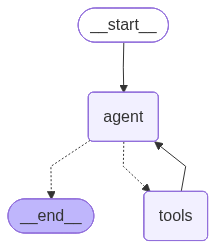

In [ ]:
from IPython.display import Image

display(Image(single_agent.get_graph().draw_mermaid_png()))

In [ ]:
!gdown 1dSyjcjlFoZpYEqv4P9Oi0-kU2gIoolMB

Downloading...
From (original): https://drive.google.com/uc?id=1dSyjcjlFoZpYEqv4P9Oi0-kU2gIoolMB
From (redirected): https://drive.google.com/uc?id=1dSyjcjlFoZpYEqv4P9Oi0-kU2gIoolMB&confirm=t&uuid=158d2147-3f7d-422f-8612-f4ba83aac071
To: /content/agent_utils.py
100% 6.45k/6.45k [00:00<00:00, 18.8MB/s]


### Stream Agent Exeuction

In [ ]:
from agent_utils import format_message

def call_agent_system(agent, prompt, verbose=False):
    events = agent.stream(
        {"messages": [("user", prompt)]},
        {"recursion_limit": 25},
        stream_mode="values"
    )
    for event in events:
        if verbose:
            format_message(event["messages"][-1])

    print('\n\nFinal Response:')
    display(Markdown(event["messages"][-1].content))

In [ ]:
prompt = "Review patient P104 for procedure justification."
call_agent_system(single_agent, prompt, verbose=True)

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Review patient P104 for procedure justification.                                                                │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── ⚙️ Tool Request ─────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: fetch_patient_record                                                                              │
│    Args: {                                                                                                      │
│   "patient_id": "P104"                                                                                          │
│ }                                                                                                               │
│    ID: call_UH1Ypn8696RJH0hXQwTdZhli                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ {"error": "Patient record not found."}                                                                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── ⚙️ Tool Request ─────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: fetch_patient_record                                                                              │
│    Args: {                                                                                                      │
│   "patient_id": "P104"                                                                                          │
│ }                                                                                                               │
│    ID: call_nBNW5Emv6epRgv4EQlpfq6hW                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ {"error": "Patient record not found."}                                                                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── ⚙️ Tool Request ─────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: fetch_patient_record                                                                              │
│    Args: {                                                                                                      │
│   "patient_id": "P104"                                                                                          │
│ }                                                                                                               │
│    ID: call_Eaa3XlxYaOxrloUxmY1aYlBG                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ {"error": "Patient record not found."}                                                                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── ⚙️ Tool Request ─────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: fetch_patient_record                                                                              │
│    Args: {                                                                                                      │
│   "patient_id": "P104"                                                                                          │
│ }                                                                                                               │
│    ID: call_iauTU6M9C78azCYMQV0cfiyY                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ {"error": "Patient record not found."}                                                                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────── 🤖 Assistant ──────────────────────────────────────────────────╮
│ - Final Decision: NEEDS REVIEW                                                                                  │
│ - Decision Reasoning: Patient record not found, unable to evaluate procedure justification.                     │
│ - Care recommendation or alternative steps: Verify patient ID and resubmit the request for patient record       │
│ retrieval.                                                                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯



Final Response:


- Final Decision: NEEDS REVIEW
- Decision Reasoning: Patient record not found, unable to evaluate procedure justification.
- Care recommendation or alternative steps: Verify patient ID and resubmit the request for patient record retrieval.